# CTM MILP Model Running Environment (DTSimplex Extension to Parent Model)

**NOTE:** When about to make a new run, please **duplicate** this notebook then add necessary graphs and things below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *

# Add more CTM models here as needed
from ctmmodels.delaythroughput import DTSimplexParentModel as NewModel
from ctmmodels.parentmodel import ParentModel as OldModel

In [2]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'dataframes/'

**Notes on the models and parameters being used:**

* Default parameters used before:

{

    time_range = 30
    time_ticks = np.arange(0, time_range+1, 1)

    parameters = {
        'r_left': 1.0/3.0,
        'r_through': 1.0/3.0,
        'r_right': 1.0/3.0,
        'sat_flow_rate': 1800,
        'time_range': time_range,
        'time_step': 2,
        'g_min': 6,
        'g_max': 20
    }

}

* Saturation flow rate was set to 1800 vphpl, as this was the closest realistic value that matched the calculations from the parent paper.

* Traffic will be distributed evenly between the 4 lanes (left, through 1, through 2, and right). This is based on previous tests where left was getting essentially 0 green time.

* Time range will be set to 60 seconds, or 30 time steps at 2 seconds per time step.

In [3]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 0.25,
    'r_through': 0.5,
    'r_right': 0.25,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20,
    'flow_rate_reduction': 1
}

# Varying parameters: demand, alpha, beta, gamma

In [4]:
def run_model(demand, weights=(0.33, 0.33, 0.33), new_model=True, log_output=True):
    if new_model:
        model = NewModel(
            demand=demand,
            alpha=weights[0],
            beta=weights[1],
            gamma=weights[2],
            **parameters
        )
    else:
        model = OldModel(
            demand=demand,
            **parameters
        )

    model.generate()
    runtime = model.solve(log_output=log_output)
    return model, runtime

## Intersection Cell Network

![title](img/4leg-intersection.png)

## Setting the path of cells to check

In [5]:
_approach = SOUTHBOUND

_approach_terms = [
    'Left',
    'Through',
    'Right'
]

_cell_path = [
    (CELL_SOURCE,0,_approach),
    (CELL_NORMAL,0,_approach),
    (CELL_NORMAL,1,_approach),
    (CELL_NORMAL,2,_approach),
    (CELL_MOVEMENT,THROUGH_TURN,_approach),
    S_mapping((CELL_MOVEMENT,THROUGH_TURN,_approach))[0]
]

def movement_paths(approach):
    return [
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,LEFT_TURN,approach),
            S_mapping((CELL_MOVEMENT,LEFT_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,THROUGH_TURN,approach),
            S_mapping((CELL_MOVEMENT,THROUGH_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,RIGHT_TURN,approach),
            S_mapping((CELL_MOVEMENT,RIGHT_TURN,approach))[0]
        ]
    ]

## Comparing cell volumes

In [6]:
def plot_volume(dfx, cell_path=_cell_path, title="Volume", headless=False, filename='volume.png'):
    dfx_approach = pd.concat([
        dfx[dfx.cell == c].sort_values(by='timestep')
        for c in cell_path
    ]).pivot(index='timestep', columns='cell', values='volume')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))
    
    sns.lineplot(data=dfx_approach, ax=axs[0])
    sns.lineplot(data=dfx_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Volume of cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous volume')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Volume of cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative volume')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing flows

In [7]:
def plot_flow(dfy, cell_path=_cell_path, title="Flows", headless=False, filename='flow.png'):
    dfy_approach = pd.concat([
        dfy[dfy.cell_from == c].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
        for c in cell_path
    ]).reset_index().pivot(index='timestep', columns='cell_from', values='flow')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))

    sns.lineplot(data=dfy_approach, ax=axs[0])
    sns.lineplot(data=dfy_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Flow from cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous flow')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Flow from cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative flow')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing specific green time

In [8]:
all_phases = [intToBinTuple(x) for x in range(8)]
all_phases_labels = [
    "Left, Westbound",
    "Through, Eastbound",
    "Left, Southbound",
    "Through, Southbound",
    "Left, Eastbound",
    "Through, Westbound",
    "Left, Northbound",
    "Through, Northbound",
]

def plot_greentime_map(dfg, title="Greentime maps", headless=False, filename='greentime.png', movements=True):
    fig, axs = plt.subplots(figsize=(18,8))

    dfg_matrix = dfg.T
    if movements:
        dfg_matrix = dfg_matrix.reindex(index=[
            (2,LEFT_TURN,EASTBOUND), (2,RIGHT_TURN,EASTBOUND), (2,THROUGH_TURN,EASTBOUND),
            (2,LEFT_TURN,NORTHBOUND), (2,RIGHT_TURN,NORTHBOUND), (2,THROUGH_TURN,NORTHBOUND),
            (2,LEFT_TURN,SOUTHBOUND), (2,RIGHT_TURN,SOUTHBOUND), (2,THROUGH_TURN,SOUTHBOUND),
            (2,LEFT_TURN,WESTBOUND), (2,RIGHT_TURN,WESTBOUND), (2,THROUGH_TURN,WESTBOUND),
        ])
    sns.heatmap(data=dfg_matrix)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

In [9]:
def plot_obj_values(obj_values, title, xaxis, xlabel, headless=True, filename='obj.png'):
    fig, axs = plt.subplots(1,2,figsize=(20,10))

    axs[0].plot(xaxis, [x[0] for x in obj_values])
    axs[0].set_title("Computed total delay")
    axs[0].set_ylabel("Total vehicle delay (timesteps)")
    axs[0].set_xlabel(xlabel)

    axs[1].plot(xaxis, [x[1] for x in obj_values])
    axs[1].set_title("Computed total throughput")
    axs[1].set_ylabel("Total vehicle throughput (veh)")
    axs[1].set_xlabel(xlabel)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Saving dataframes

In [10]:
def save_df(df, filename):
    df.to_pickle(DF_PATH + filename + ".pkl")

## Generating dataframes

In [11]:
_demands = [
    450,
    900,
    (450, 900),
    (900, 1800)
]

_points = [
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (0.5, 0.5, 0),
    (0, 0.5, 0.5),
    (0.5, 0, 0.5),
    (0.33, 0.33, 0.33),
    (0, 0, 0),
]

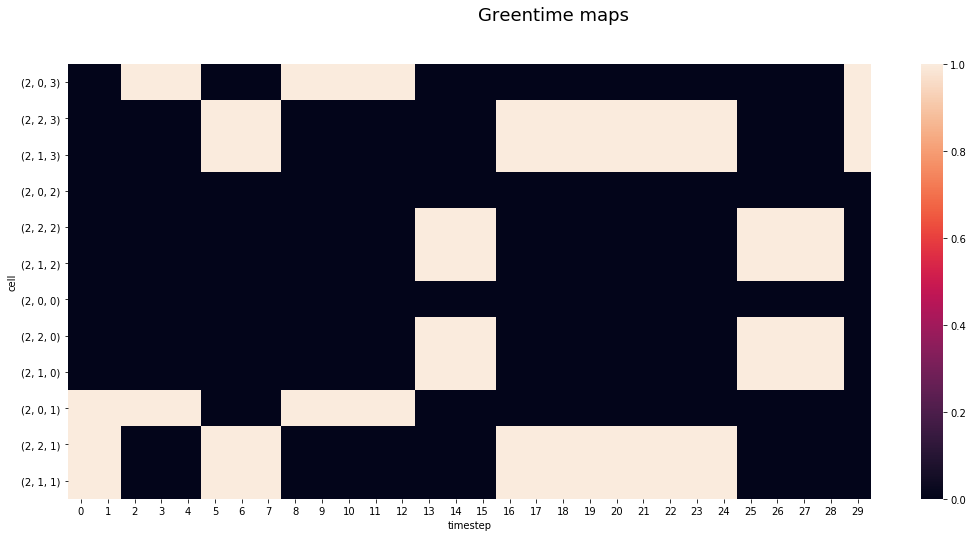

In [22]:
dfg = pd.read_pickle(DF_PATH + "newextension/greentimes/greentimes_d(450, 900)_new_a0_b1_c0.pkl")
plot_greentime_map(dfg)

In [15]:
model.model.name

'Parent Model with DTSimplex Extension'

In [17]:
model.set_CC_LR

[((2, 0, 0), (2, 2, 1)),
 ((2, 0, 1), (2, 2, 2)),
 ((2, 0, 2), (2, 2, 3)),
 ((2, 0, 3), (2, 2, 0))]

In [24]:
model.model.name = "Bitch man"

In [25]:
model.model.name

'Bitch man'